In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys

from utils.data_utils import SAMPLING_FREQUENCY, load_data
from custom.models import get_multi_output_model

import tensorflow as tf
from tensorflow import keras

## Prerequisites

Specify the directory where the data is stored.

In [2]:
ROOT_DIR = '/mnt/neurogeriatrics_data/MobiliseD_TVS/rawdata' if sys.platform == 'linux' else 'Z:\\MobiliseD_TVS\\rawdata'

Get train and test data, where the proportion of test data is 20% of the subjects.

In [3]:
train_data, test_data = load_data(path=ROOT_DIR, sequence_length=10., overlap=0., test_size=0.2)

Split the train data into features and labels. For the labels, differentiate between labels for gait sequences and gait events.

In [4]:
train_features, train_labels = train_data[:,:,:-2], train_data[:,:,-2:]
gait_labels = np.expand_dims(train_labels[:,:,0], axis=-1)
event_labels = np.expand_dims(train_labels[:,:,1], axis=-1)
event_labels = keras.utils.to_categorical(event_labels)
print(f'Shape of train features: {train_features.shape}')
print(f'Shape of gait labels: {gait_labels.shape}')
print(f'Shape of event labels: {event_labels.shape}')

Shape of train features: (16592, 640, 12)
Shape of gait labels: (16592, 640, 1)
Shape of event labels: (16592, 640, 5)


Get a multi-output model that simultaneously classifies gait sequences as well as specific gait events.

2022-06-20 13:11:47.647944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 13:11:47.670922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 13:11:47.671043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 13:11:47.671417: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 12)]   0           []                               
                                                                                                  
 tcn (TCN)                      (None, None, 64)     167360      ['inputs[0][0]']                 
                                                                                                  
 gait_sequences (Dense)         (None, None, 1)      65          ['tcn[0][0]']                    
                                                                                                  
 concat (Concatenate)           (None, None, 65)     0           ['tcn[0][0]',                    
                                                                  'gait_sequences[0][0]'] 

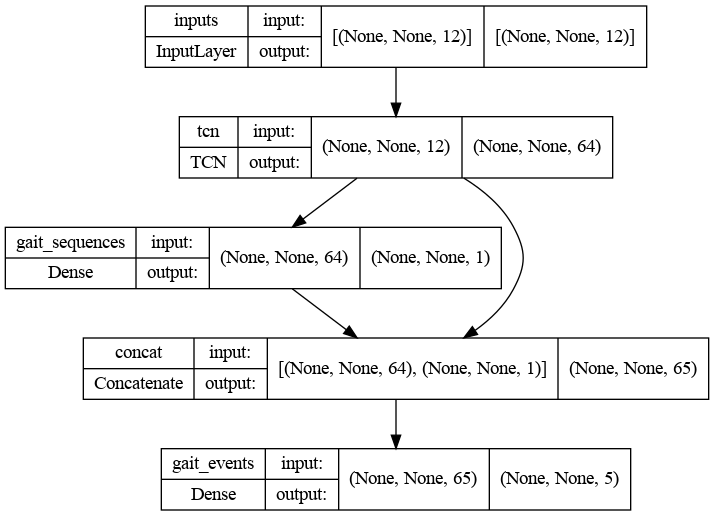

In [5]:
multi_output_model = get_multi_output_model(nb_channels=train_features.shape[-1], nb_classes=event_labels.shape[-1])
multi_output_model.summary()
keras.utils.plot_model(multi_output_model, show_shapes=True)

In [6]:
multi_output_history = multi_output_model.fit(
    x = train_features,
    y = {'gait_sequences': gait_labels,
         'gait_events': event_labels},
    batch_size = 16,
    epochs = 5,
    shuffle = True
)

Epoch 1/5


2022-06-20 13:11:51.872386: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-06-20 13:11:52.202057: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1037/1037 [==============================] - 16s 12ms/step - loss: 0.0920 - gait_sequences_loss: 0.0694 - gait_events_loss: 0.0226 - gait_sequences_binary_accuracy: 0.9779 - gait_sequences_categorical_accuracy: 1.0000 - gait_events_binary_accuracy: 0.9979 - gait_events_categorical_accuracy: 0.9950
Epoch 2/5
1037/1037 [==============================] - 13s 12ms/step - loss: 0.0566 - gait_sequences_loss: 0.0451 - gait_events_loss: 0.0116 - gait_sequences_binary_accuracy: 0.9837 - gait_sequences_categorical_accuracy: 1.0000 - gait_events_binary_accuracy: 0.9986 - gait_events_categorical_accuracy: 0.9965
Epoch 3/5
1037/1037 [==============================] - 13s 12ms/step - loss: 0.0521 - gait_sequences_loss: 0.0412 - gait_events_loss: 0.0109 - gait_sequences_binary_accuracy: 0.9847 - gait_sequences_categorical_accuracy: 1.0000 - gait_events_binary_accuracy: 0.9986 - gait_events_categorical_accuracy: 0.9965
Epoch 4/5
1037/1037 [==============================] - 13s 12ms/step - loss: 0.0487